In [3]:
from IPython.display import display, HTML, Audio
display(HTML("<style>.container {width: 100%; important! }</style>"))
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [4]:
fname_1 = 'original_sound/borya_Karim.wav'
fname_2 = 'original_sound/motivation_Aynur.wav'
fs, audio_in_1 = wavfile.read(fname_1)
fs, audio_in_2 = wavfile.read(fname_2)

In [5]:
if audio_in_1.shape[0] > audio_in_2.shape[0]:
    audio_in_2 = np.concatenate((np.zeros(audio_in_1.shape[0] - audio_in_2.shape[0]), audio_in_2))
else:
    audio_in_1 = np.concatenate((np.zeros(audio_in_2.shape[0] - audio_in_1.shape[0]), audio_in_1))

In [6]:
unmixed = np.vstack([audio_in_1, audio_in_2])
unmixed = unmixed - np.expand_dims(unmixed.mean(1), axis=1)
unmixed = unmixed/np.expand_dims(np.std(unmixed, axis=1), axis=1)

In [9]:
unmixed.mean(1)
np.std(unmixed, axis=1)

array([1., 1.])

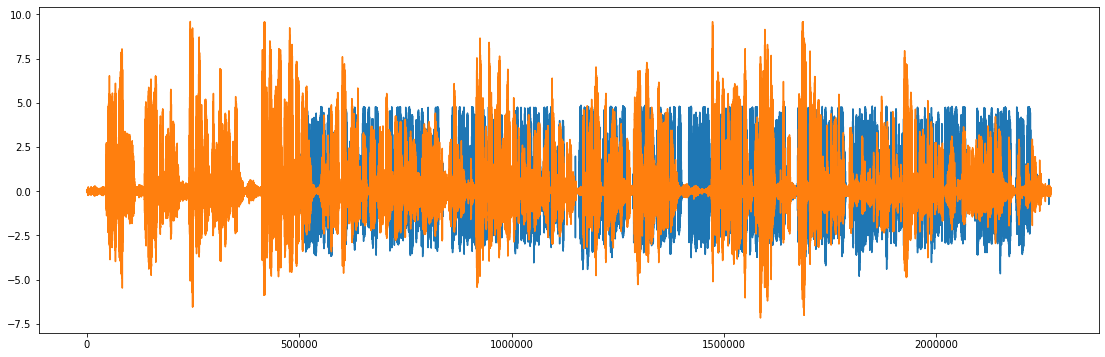

In [10]:

plt.plot(unmixed[0])
plt.plot(unmixed[1])

In [11]:
mixture_matrix = np.array([[2.1, 1], [1.2, 1.7]])
mixed = mixture_matrix @ unmixed

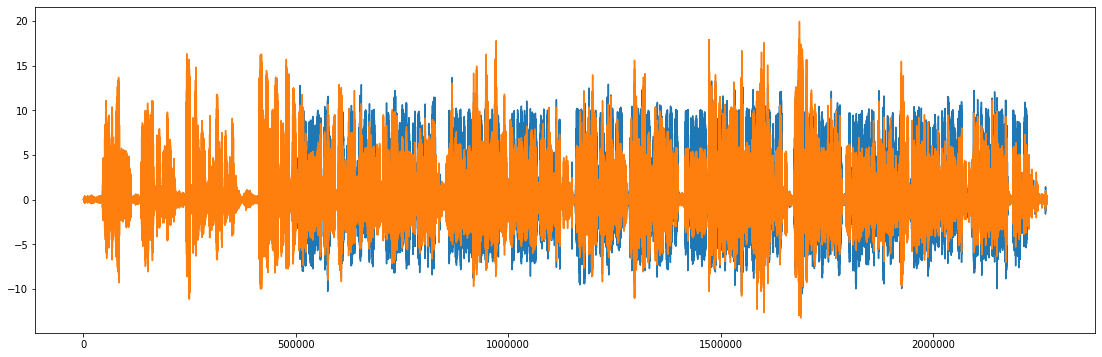

In [12]:
plt.figure(figsize=(19,6))
plt.plot(mixed[0])
plt.plot(mixed[1])

## Preprocessing

In [13]:
def center(signal):
    return signal - np.expand_dims(signal.mean(axis=1), axis=1)

def white(signal):
    matrix = np.cov(signal)
    w, E = np.linalg.eig(matrix)
    D = np.sqrt(np.linalg.pinv(np.diag(w)))
    M = E @ D @ E.T
    return M @ signal

def preprocess(signal):
    return white(center(signal))

In [14]:
print(np.linalg.inv(mixture_matrix))

[[ 0.71729958 -0.42194093]
 [-0.50632911  0.88607595]]


In [15]:
preprocessed = preprocess(mixed)

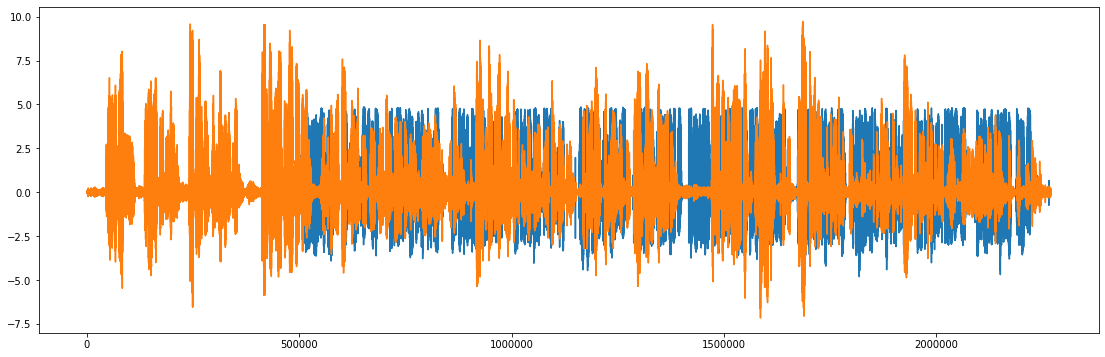

In [16]:
plt.figure(figsize=(19,6))
plt.plot(preprocessed[0])
plt.plot(preprocessed[1])

In [17]:
def derivG2(u):
    return u*np.exp(-(1/2)*u**2)

In [18]:
def deriv_deriv_G(u):
    return (1 - u**2)*np.exp(-(1/2)*u**2)

In [19]:
def converge_criterium(prev_w, curr_w, eps=0.01):
    if np.abs(prev_w.T@curr_w) < (1 - eps):
        return True
    else:
        return False
    

In [20]:
deriv_deriv_G(5)

-8.94396761298881e-05

In [21]:
curr_w = np.random.rand(mixed.shape[0])
prev_w = np.random.rand(mixed.shape[0])
curr_w = curr_w / np.linalg.norm(curr_w)
prev_w = prev_w / np.linalg.norm(prev_w)

In [22]:
converge_criterium(prev_w, curr_w)

True

In [20]:
# prev_v = curr_w.copy()


In [23]:
curr_w.T@mixed

array([-0.0010922 , -0.0010922 , -0.0010922 , ..., -0.0057169 ,
        0.01318204, -0.24778144])

In [24]:
(mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1]

array([0.16759456, 0.16813928])

In [25]:
curr_w = (mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1] - curr_w*(deriv_deriv_G(curr_w.T @ mixed)).mean()
curr_w = curr_w / np.linalg.norm(curr_w)

In [26]:
eps = 0.00001

In [27]:
while converge_criterium(prev_w, curr_w):
    prev_w = curr_w.copy()
    curr_w = (((preprocessed @ derivG2(curr_w.T @ preprocessed)) / preprocessed.shape[1]) 
              - curr_w*(deriv_deriv_G(curr_w.T @ preprocessed)).mean())
    curr_w = curr_w / np.linalg.norm(curr_w)

In [28]:
curr_w

array([ 0.8947089 , -0.44664973])

In [29]:
np.linalg.inv(mixture_matrix)

array([[ 0.71729958, -0.42194093],
       [-0.50632911,  0.88607595]])

In [38]:
def result_from_ICA():
    res = curr_w.T@preprocessed
    # res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
    res = res/np.abs(res).max()
    res = (res*32767).astype(np.int16)
    wavfile.write('once_ch_unmix_bor_mot_res.wav', rate=fs, data=res)
    return res

result_ICA = result_from_ICA()

In [39]:
# res = curr_w.T@preprocessed
def result_from_inv():
    res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
    res = res/np.abs(res).max()
    res = (res*32767).astype(np.int16)
    wavfile.write('once_ch_unmix_bor_mot_inv.wav', rate=fs, data=res)
    return res

result_inv = result_from_inv()

In [34]:
Audio("once_ch_unmix_bor_mot_res.wav")

In [40]:
def plot_sound(x, y, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    ax.plot(x, y)
    ax.set_xlabel("time, $s$")
    ax.set_ylabel("amplitude")

In [44]:
result_ICA.shape

(2268945,)

/home/aynur/Installed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  """
/home/aynur/Installed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


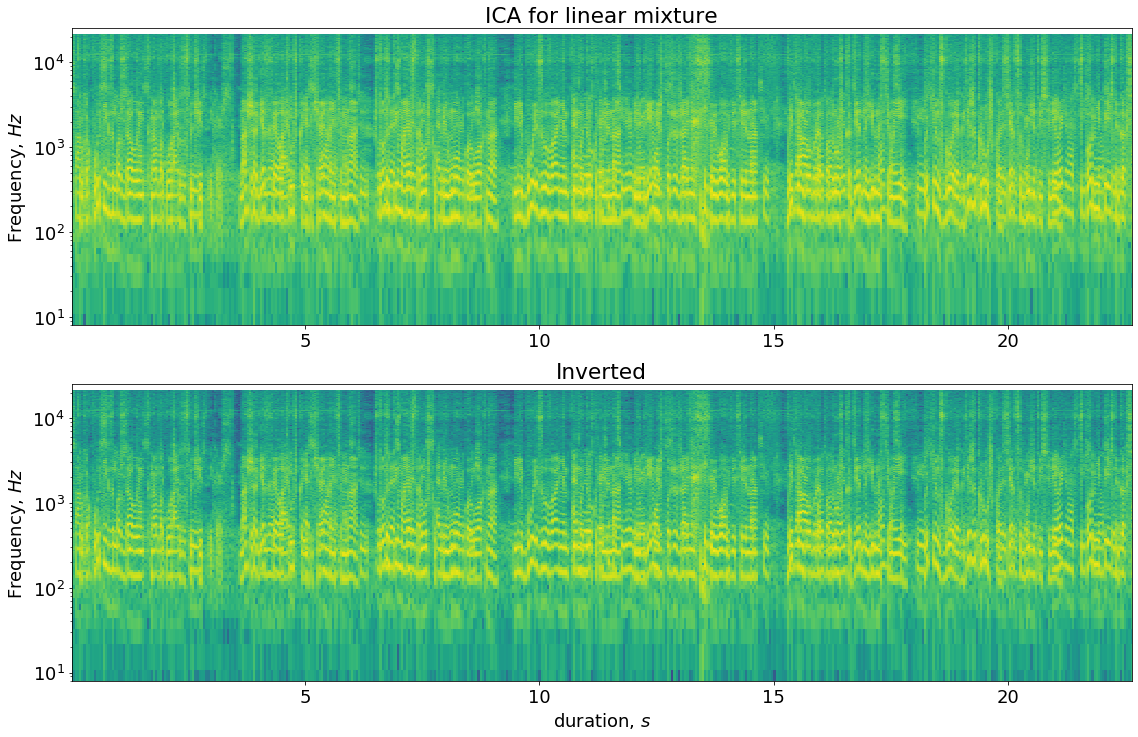

In [74]:
fig, ax = plt.subplots(2, 1, figsize=(19, 12))
# plt.tight_layout()
plt.rcParams.update({'font.size': 18})
ax[0].set_yscale('log')
ax[0].specgram(result_ICA[1000000:2000000], Fs=44100, scale='dB', NFFT=4096, noverlap=2048)
ax[0].set_ylim(8, 2.5e4)
ax[0].set_title("ICA for linear mixture")
# ax[0].set_xlabel("duration, $s$")
ax[0].set_ylabel("Frequency, $Hz$")
ax[1].set_ylabel("Frequency, $Hz$")
ax[1].set_yscale('log')
ax[1].specgram(result_inv[1000000:2000000], Fs=44100, scale='dB', NFFT=4096, noverlap=2048)
ax[1].set_ylim(8, 2.5e4)
ax[1].set_title("Inverted")
ax[1].set_xlabel("duration, $s$")

fig.savefig("ICA_linear.png")